# Bella Beat Case Study
Este proyecto hace parte del certificado profesional en análisis de datos de Google.
Queremos responder las siguientes preguntas:

* Cuáles son las tendencias en el uso de los dispositivos de rastreo de indicadores de salud?
* Cómo podrían dichas tendencias aplicar a los clientes de Bellabeat?
* Cómo podrían ayudar dichas tendencias a la estrategia de marketing de BellaBeat?

Bellabeat es una compañía que vende dispositivos tecnológicos que permiten rastrear varios indicadores de salud, por ejemplo ritmo cardíaco, calorías, sueño, etc. Aquí queremos encontrar tendencias en el uso de un dispostivo concreto "Fitbit". Los datos se encuentran en [Kaggle](https://www.kaggle.com/datasets/arashnic/fitbit) de forma abierta. Fueron suministrados por 30 usuarios de dicho dispositivo y contienen información detallada minuto a minuto de sus indicadores de salud.

El orden del NoteBook es el siguiente:

1) Limpieza de datos.
2) Análisis de datos.

Hacía el final se encuentra un apéndice donde se cargan los datos y se analiza, de forma pre-eliminar, la estructura y la relación de los conjuntos de datos.




In [1]:
import pandas as pd
import numpy as np 

#Graphical Libraries
import matplotlib.pyplot as plt
import seaborn as sns


## 1. Data cleaning

Para la limpieza de datos tenga en cuenta que los datos ya se encuntran cargados. **Corra primero el apéndice**.
La serie all_df contiene todos los dataFrames indexados por sus nombres. 

Para la limpieza de datos vamos a empezar analizando los datasets cuyo nombre es 'minutesXNarrow' que son, de acuerdo a los descubrimientos del apéndice, los datos con los que se construyen los demás datasets.
Tenemos 4 de ellos, a saber:
* minuteCaloriesNarrow_merged -- Calorias
* minuteIntensitiesNarrow_merged -- Intensidades
* minuteMETsNarrow_merged -- MET
* minuteStepsNarrow_merged -- Step

Adicionalmente tenemos los datasets:
minuteSleep_merged, heartrate_seconds_merged y weightLogInfo_merged que necesitan más investigación.

Iniciaremos con algunos 'Sanity Checks'.


### Cantidad de registros

In [20]:

count_calories = all_df['minuteCaloriesNarrow_merged'].groupby(['Id']).size().sort_values(ascending = False).reset_index()
count_intensities = all_df['minuteIntensitiesNarrow_merged'].groupby(['Id']).size().sort_values(ascending = False).reset_index()
count_MET = all_df['minuteMETsNarrow_merged'].groupby(['Id']).size().sort_values(ascending = False).reset_index()
count_Steps = all_df['minuteStepsNarrow_merged'].groupby(['Id']).size().sort_values(ascending = False).reset_index()

# Son iguales la cantidad de registros
(count_calories.equals(count_intensities)) and ( count_intensities.equals(count_MET)) and \
(count_MET.equals(count_Steps))

True

Resulta que la cantidad de registros son iguales para cada id en los 4 datasets cuyo nombre es la forma 'MinuteXNarrow' (Por eso es True el resultado anterior.)

### Rango de días (Span Days represented)
A continuación analizamos el rango de días que cubren los datos. Recuerde que tenemos información por minuto, así que ahora respondemos, ¿cuántos días equivalen a dichos minutos? o cuántos y quedías están representados en los datasets?

Text(0, 0.5, "Number of Id's")

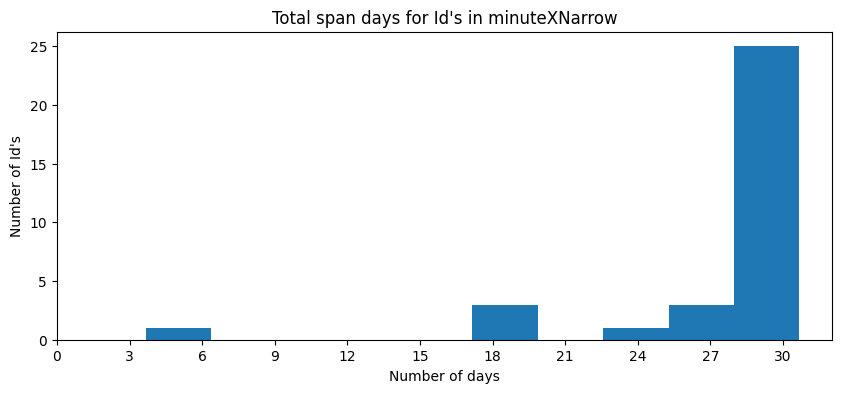

In [21]:
ax = count_calories.set_index('Id').div(60).div(24).plot(figsize = (10,4),\
                                                         use_index = False, \
                                                         title = "Total span days for Id's in minuteXNarrow",\
                                                         kind= 'hist',\
                                                         legend= False,
                                                         xticks = np.arange(0,33,3, dtype = 'int'))
ax.set_xlabel('Number of days')
ax.set_ylabel("Number of Id's")

Abajo podemos ver la cantidad exacta de días representados pars cada id (los datos están transpuestos para ahorrar espacio de visualización). El mínimo es 3.6 días. La diferencia de días hace que los distintos Id's no sean directamente comparables. 
En este contexto, lo más sensato es no tener en cuenta los Id's que tienen poca representación puesto que pueden sesgar nuestros datos negativamente al realizar agregaciones en el futuro.

In [22]:
count_calories.set_index('Id').div(24).div(60).T.sort_values(by = 0, axis='columns', ascending = False)

Id,1927972279,2026352035,2873212765,4558609924,1624580081,4388161847,8053475328,2022484408,2320127002,8877689391,...,3977333714,8792009665,6290855005,6117666160,6775888955,7007744171,3372868164,8253242879,2347167796,4057192912
0,30.666667,30.666667,30.666667,30.666667,30.666667,30.625,30.625,30.625,30.625,30.583333,...,29.0,28.0,27.708333,27.5,25.416667,25.041667,19.666667,17.958333,17.25,3.666667


Convertimos los datos temporales a formato datetime para realizar cálculos sobre las fechas.

In [24]:
# Renombramos los Datasets por comodidad.
calories = all_df['minuteCaloriesNarrow_merged']
intensities = all_df['minuteIntensitiesNarrow_merged']
MET = all_df['minuteMETsNarrow_merged']
steps = all_df['minuteStepsNarrow_merged']

In [25]:
# We convert ActivityMinute to datetime. Calories already converted in appendix. 
# We also create a Day_and_hour to help group by in the future

# calories['datetime'] = pd.to_datetime( calories.pop('ActivityMinute'), \
#                                           format = '%m/%d/%Y %I:%M:%S %p' )

# Intensidades ---
intensities['datetime'] = pd.to_datetime( intensities.pop('ActivityMinute'), \
                                          format = '%m/%d/%Y %I:%M:%S %p' )
intensities['Day_and_hour'] = intensities['datetime'].dt.strftime('%Y-%m-%d %H')

# MET ----
MET['datetime'] = pd.to_datetime( MET.pop('ActivityMinute'), \
                                          format = '%m/%d/%Y %I:%M:%S %p' )
MET['Day_and_hour'] = MET['datetime'].dt.strftime('%Y-%m-%d %H')


#Steps -----
steps['datetime'] = pd.to_datetime( steps.pop('ActivityMinute'), \
                                    format = '%m/%d/%Y %I:%M:%S %p' )
steps['Day_and_hour'] = steps['datetime'].dt.strftime('%Y-%m-%d %H')


A continuación analizamos el rango explícito de fechas con horas que cubre cada Id.
Notamos lo siguiente: El mínimo siempre es 2016-04-12 00:00:00 y el máximo varía demasiado. Siendo 2016-05-12 15:59:00 es valor más alto.

In [27]:
# Exploremos los rangos minimos y maximos de fechas.
max_min_dates_table = calories.groupby('Id').agg(min_date = ('datetime', 'min'),
                           max_date = ('datetime', 'max'))
max_min_dates_table

,min_date,max_date
Id,,
1503960366,2016-04-12,2016-05-11 20:59:00
1624580081,2016-04-12,2016-05-12 15:59:00
1644430081,2016-04-12,2016-05-11 11:59:00
1844505072,2016-04-12,2016-05-12 10:59:00
1927972279,2016-04-12,2016-05-12 15:59:00
2022484408,2016-04-12,2016-05-12 14:59:00
2026352035,2016-04-12,2016-05-12 15:59:00
2320127002,2016-04-12,2016-05-12 14:59:00
2347167796,2016-04-12,2016-04-29 05:59:00


### Filtro por rango de fechas común
Decidimos solo considerar los Id's que cuentan con el rango completo:
2016-04-12 00:00:00 - 2016-05-12 00:00:00.

De esta manera tenemos uniformidad en los registros de los clientes y podemos estar seguros de hacer comparaciones completas entre los mismos.

In [28]:
from datetime import datetime
limit_date = datetime.strptime('2016-05-11 23:59:01', '%Y-%m-%d %H:%M:%S')

ids_full_month = max_min_dates_table[max_min_dates_table['max_date'] >= limit_date].index

#Just id's with full month
calories = calories.loc[calories['Id'].isin(ids_full_month)]
intensities = intensities.loc[intensities['Id'].isin(ids_full_month)]
MET = MET.loc[MET['Id'].isin(ids_full_month)]
steps = steps.loc[steps['Id'].isin(ids_full_month)]

# Now, delete extra records.
calories = calories.loc[calories['datetime']<limit_date]
intensities = intensities.loc[intensities['datetime']<limit_date]
MET = MET.loc[MET['datetime']<limit_date]
steps = steps.loc[steps['datetime']<limit_date]


### Duplicados
Como podemos observar a continuación no hay valores duplicados por Id y fecha.

In [36]:
print(calories.duplicated(['Id', 'datetime']).sum())
print(intensities.duplicated(['Id', 'datetime']).sum())
print(MET.duplicated(['Id', 'datetime']).sum())
print(steps.duplicated(['Id', 'datetime']).sum())

0
0
0
0


### Consistencia de las fechas
Para verificar que nuestra limpieza es correcta, debemos asegurarnos de que la fecha que estamos cubriendo es la correcta.De acuerdo a lo que hemos hecho nuestro span de fechas debe coincidir con el span desde 2016-04-12 00:00:00 hasta 2016-05-11 23:59:00 minuto a minuto.

In [62]:
rango_completo = pd.Series(pd.date_range('2016-04-12 00:00:00', '2016-05-11 23:59:00' , freq= 'T'))
rango_completo

0       2016-04-12 00:00:00
1       2016-04-12 00:01:00
2       2016-04-12 00:02:00
3       2016-04-12 00:03:00
4       2016-04-12 00:04:00
                ...        
43195   2016-05-11 23:55:00
43196   2016-05-11 23:56:00
43197   2016-05-11 23:57:00
43198   2016-05-11 23:58:00
43199   2016-05-11 23:59:00
Length: 43200, dtype: datetime64[ns]

In [72]:
def ver_rango_completo(group):
    return (group.datetime.reset_index(drop=True)).equals(rango_correcto)
# Añade columna booleana que evalua para cada id si el rango de datetime es igual rango_completo.
# Depués con all() devuelve True indicando que todos los Id's tienen el rango completo.
print(calories.groupby('Id').apply(ver_rango_completo).all())
print(intensities.groupby('Id').apply(ver_rango_completo).all())
print(MET.groupby('Id').apply(ver_rango_completo).all())
print(steps.groupby('Id').apply(ver_rango_completo).all())

True
True
True
True


### Sueño

Notamos 
1) No todos los id's de los datos anteriores están representados. En realidad solo hay 15 de los 19. Para los otros 4 no hay datos.
2) Muy pocos id's tienen varios registros. De hecho lo normal es que falten varios registros de sueño.

<AxesSubplot:xlabel='Id'>

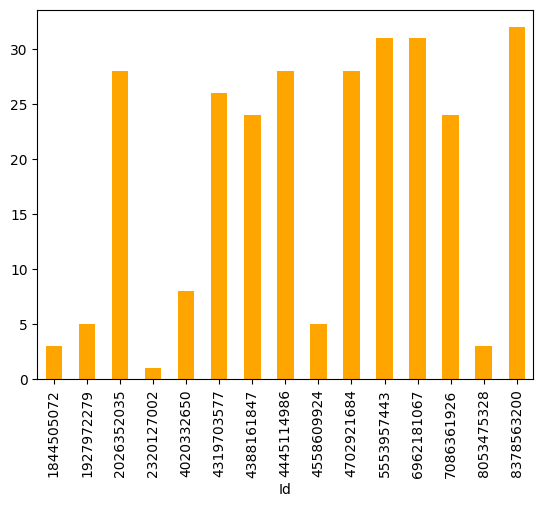

In [102]:
sleep = all_df['sleepDay_merged'].copy()
sleep = sleep[sleep['Id'].isin(ids)] #Filtramos por Id

# Representan cuánto se durmió entre la noche anterior y el día actual.
sleep['datetime'] = pd.to_datetime(sleep.pop('SleepDay') , format = '%m/%d/%Y %I:%M:%S %p' )

sleep.groupby('Id')['datetime'].agg('count').plot(kind= 'bar', color = 'orange')

In [128]:
sleep.groupby('Id').agg(min_date = ('datetime', 'min'),\
                        max_date = ('datetime', 'max'), \
                        count = ('datetime', 'count')).sort_values(by = 'count', ascending = False)

,min_date,max_date,count
Id,,,
8378563200,2016-04-12,2016-05-12,32
5553957443,2016-04-12,2016-05-12,31
6962181067,2016-04-12,2016-05-12,31
2026352035,2016-04-12,2016-05-12,28
4445114986,2016-04-12,2016-05-12,28
4702921684,2016-04-12,2016-05-12,28
4319703577,2016-04-14,2016-05-12,26
4388161847,2016-04-15,2016-05-11,24
7086361926,2016-04-12,2016-05-12,24


En este punto lo conveniente sería -de acuerdo al certificado porf. de Google- preguntar al dueño del conjunto de datos sobre las posibles razones de la ausencia de datos y su recomendación para tratar la ausencia de información del sueño ¿Conviene descartar esta información?

Otra posibilidad sería cambiar de conjunto de datos. Sin embargo, dado que el meta-objetivo del proyecto es demostrar habilidades de análisis de datos optamos por la siguiente metodología:

1) Interpolar los datos faltantes para los Id's que se encuentran presentes.
2) Para los Id's faltantes haremos un statistical matching que permita encontrar los id's más similares.

#### Interpolación de minutos de sueño y minutos en cama

A continuación interpolamos el tiempo de sueño y el tiempo de cama para los 15 id's presentes en el dataset sleep. Interpolamos de la siguiente manera:
Para cada día faltante creamos un valor aleatorio con distribución $normal$($\mu_{id} $ , $\sigma_{id} $). Donde $\mu_{id} $  representa el promedio del respectivo id y $\sigma_{id} $ indica la desviación estándar de los registros disponibles del respectivo id. En el caso del Id que tiene un solo registro usamos una desviación estándar de 1. De esta manera los valores de sueño tienen una distribución normal. En particular los Id's con registros de sueño menos volatiles tienen valores aleatorios menos volatiles. Los que cuentan con todos los registros se mantienen inalterados.

El código de abajo puede paracer largo y tedioso. Pero en realidad se puso de esta manera para que el proceso paso a paso sea más evidente. Nota: El código puede ser lento en un dataset grande.

In [265]:
test = sleep.copy()
np.random.seed(13)
dates_index = pd.DatetimeIndex(calories.datetime.dt.date.unique())

all_sleep = []
for iden in test['Id'].unique():
    group = test[test['Id'] == iden]
    mu = group['TotalMinutesAsleep'].mean()
    if np.isnan(group['TotalMinutesAsleep'].std()):
        sigma = 1
    else:
        sigma = group['TotalMinutesAsleep'].std()
    try:
        old_index_series = group.set_index('datetime')
        new_series = old_index_series.loc[~old_index_series.index.duplicated()]
        new_series = new_series['TotalMinutesAsleep'].reindex(dates_index)
    except:
        print(iden)
        break
    #Interpolamos los valores faltantes con valores aleatorios de normal(mu,sigma). Estimamos que los usuarios duermen con una distr normal.
    fulled = new_series.map(lambda x: x if not np.isnan(x) else int(mu + sigma* np.random.standard_normal(size = 1))) 
    df = fulled.to_frame().reset_index().rename({'index': 'datetime'},axis = 'columns' )
    df['Id'] = iden
    
    
    # REPETIMOS PERO CON TotalTimeInBed ------------------------------------------------------------
    group2 = test[test['Id'] == iden]
    mu2 = group['TotalTimeInBed'].mean()
    if np.isnan(group['TotalTimeInBed'].std()):
        sigma2 = 1
    else:
        sigma2 = group['TotalTimeInBed'].std()
    try:
        old_index_series2 = group2.set_index('datetime')
        new_series2 = old_index_series2.loc[~old_index_series2.index.duplicated()]
        new_series2 = new_series2['TotalTimeInBed'].reindex(dates_index)
    except:
        print(iden)
        break
    fulled2 = new_series2.map(lambda x: x if not np.isnan(x) else int(mu2 + sigma2* np.random.standard_normal(size = 1)))
    df2 = fulled2.to_frame().reset_index().rename({'index': 'datetime'},axis = 'columns' )
    df2['Id'] = iden
    
    full_df = df.merge(df2, on = ['Id', 'datetime'])
    all_sleep.append(full_df)

In [269]:
new_sleep = pd.concat(all_sleep, ignore_index = True)
new_sleep = new_sleep[['Id','datetime','TotalMinutesAsleep', 'TotalTimeInBed']]
new_sleep

,Id,datetime,TotalMinutesAsleep,TotalTimeInBed
0,1844505072,2016-04-12,604.0,961.0
1,1844505072,2016-04-13,702.0,961.0
2,1844505072,2016-04-14,649.0,961.0
3,1844505072,2016-04-15,644.0,961.0
4,1844505072,2016-04-16,681.0,961.0
...,...,...,...,...
445,8378563200,2016-05-07,459.0,513.0
446,8378563200,2016-05-08,545.0,606.0
447,8378563200,2016-05-09,359.0,399.0
448,8378563200,2016-05-10,342.0,391.0


In [283]:
#sanity check el id = 5553957443 tiene todos los registros. Corra esta linea solo para verificación.
for i in range(len(new_sleep[new_sleep['Id'] == 5553957443])):
    x= sleep[sleep['Id'] == 5553957443].set_index('datetime')['TotalMinutesAsleep']
    y= new_sleep[new_sleep['Id'] == 5553957443].set_index('datetime')['TotalMinutesAsleep']
    print(x[i], y[i], x[i] == int(y[i]))


441 441.0 True
455 455.0 True
357 357.0 True
377 377.0 True
651 651.0 True
350 350.0 True
520 520.0 True
357 357.0 True
658 658.0 True
399 399.0 True
322 322.0 True
631 631.0 True
553 553.0 True
433 433.0 True
412 412.0 True
347 347.0 True
421 421.0 True
450 450.0 True
775 775.0 True
622 622.0 True
409 409.0 True
380 380.0 True
447 447.0 True
419 419.0 True
400 400.0 True
442 442.0 True
568 568.0 True
453 453.0 True
418 418.0 True
463 463.0 True


#### Matching via Nearest Neighbor (Euclidean distance).

Statistical matching se refiere a una serie de técnicas para identificar (o estratificar) en dos grupos de poblaciones las observaciones más similares con el fin de evaluar el efecto de un tratamiento y asi evitar _cofounding_.

Varios métodos han sido propuestos, uno de los más populares ha sido Propensity Score Matching. Sin embargo, recientemente este método ha recibido serias criticas. Ver [Wikipedia](https://en.wikipedia.org/wiki/Matching_(statistics)).

En este caso, usaremos un algoritmo que encuentra el vecino más cercano en distancia euclidea utilizando np.linalg.norm.

In [336]:
ids_faltantes = list(set(calories.Id.unique())-set(new_sleep.Id.unique()))

calories_presentes = calories[~calories['Id'].isin(ids_faltantes)] 
calories_faltantes = calories[calories['Id'].isin(ids_faltantes)]

In [338]:

ids_fal = []
near = []
for id_fal in calories_faltantes.Id.unique():
    norms = list()
    index = list()
    for id_pre in calories_presentes.Id.unique():
        serie_a = calories_presentes.set_index(['Id','datetime'])['Calories'].sort_index().loc[id_pre]
        serie_b = calories_faltantes.set_index(['Id','datetime'])['Calories'].sort_index().loc[id_fal]
        # Calcula la distancia euclidea.
        norms.append((np.linalg.norm(serie_a-serie_b)))
        index.append(id_pre)
    vals = pd.Series(norms, index = index)
    near.append(vals.idxmin())
    ids_fal.append(id_fal)
    

Vemos que en particular hay un id que está muy cercano a la mayoría: 1927972279

In [339]:
df_nearest = pd.DataFrame({'id_fal':ids_fal, 'near_id': near})
df_nearest

,id_fal,near_id
0,1624580081,1844505072
1,2022484408,1927972279
2,2873212765,1927972279
3,8877689391,1927972279


Encontramos que al considerar la distancia euclidea las series de timepo tienen formas muy diferentes,a pesar de minimizar la distancia punto a punto. 

array([<AxesSubplot:xlabel='datetime'>, <AxesSubplot:xlabel='datetime'>,
       <AxesSubplot:xlabel='datetime'>, <AxesSubplot:xlabel='datetime'>],
      dtype=object)

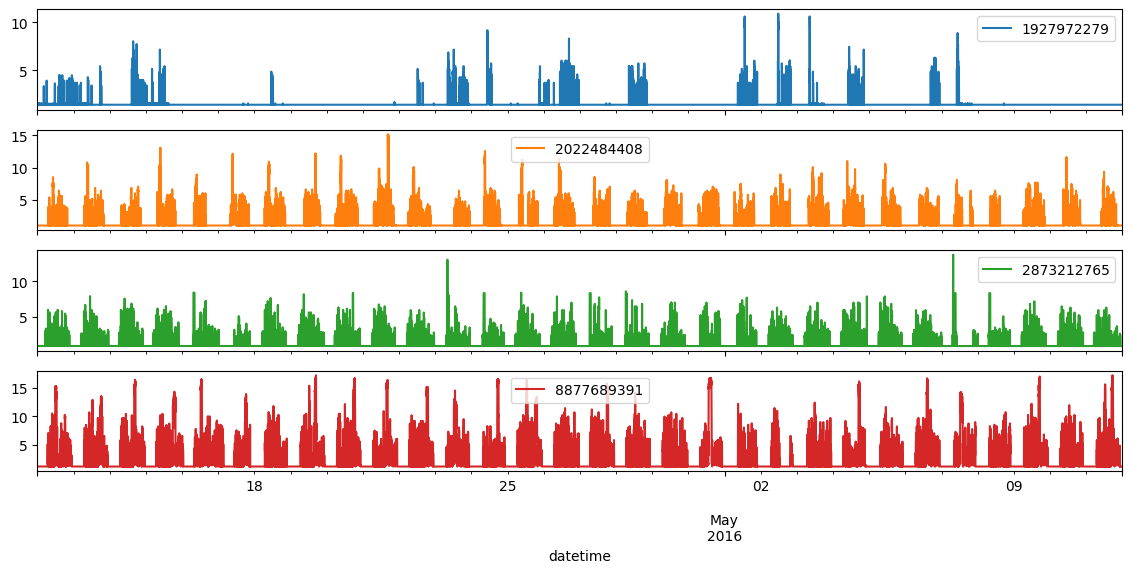

In [366]:
specials = [1927972279, 2022484408, 2873212765, 8877689391]
calories.set_index('Id').loc[specials].reset_index().pivot(index= 'datetime',\
                                                           columns = 'Id', \
                                                           values = 'Calories')\
.plot(subplots= True, figsize = (14,6))

array([<AxesSubplot:xlabel='datetime'>, <AxesSubplot:xlabel='datetime'>],
      dtype=object)

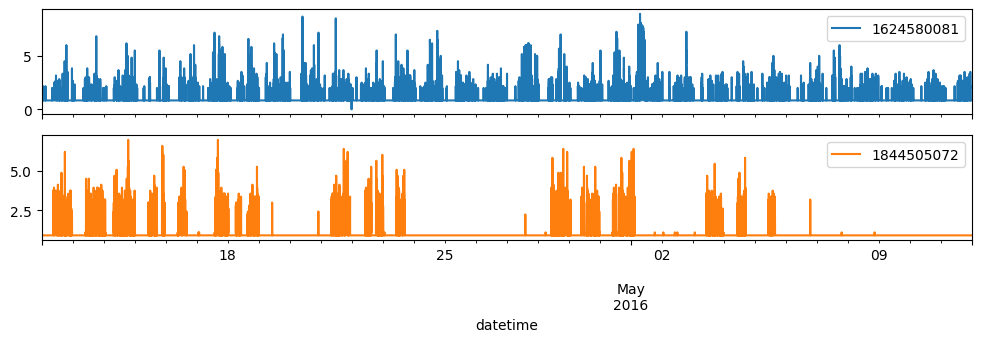

In [379]:
specials = [1624580081 , 1844505072]
calories.set_index('Id').loc[specials].reset_index().pivot(index= 'datetime',\
                                                           columns = 'Id', \
                                                           values = 'Calories')\
.plot(subplots= True, figsize = (12,3))

#### Matching via Correlation

Otra alternativa sería usar la correlación. Como se expone [aquí](https://tech.gorilla.co/how-can-we-quantify-similarity-between-time-series-ed1d0b633ca0).

In [374]:
ids_fal = []
near = []
for id_fal in calories_faltantes.Id.unique():
    norms = list()
    index = list()
    for id_pre in calories_presentes.Id.unique():
        serie_a = calories_presentes.set_index(['Id','datetime'])['Calories'].sort_index().loc[id_pre]
        serie_b = calories_faltantes.set_index(['Id','datetime'])['Calories'].sort_index().loc[id_fal]
        # Calcula la correlación de Pearson.
        norms.append(serie_a.corr(serie_b))
        index.append(id_pre)
    vals = pd.Series(norms, index = index)
    near.append(vals.idxmax())
    ids_fal.append(id_fal)
    

In [375]:
df_nearest_corr = pd.DataFrame({'id_fal':ids_fal, 'near_id': near})
df_nearest_corr

,id_fal,near_id
0,1624580081,6962181067
1,2022484408,6962181067
2,2873212765,6962181067
3,8877689391,7086361926


array([<AxesSubplot:xlabel='datetime'>, <AxesSubplot:xlabel='datetime'>,
       <AxesSubplot:xlabel='datetime'>, <AxesSubplot:xlabel='datetime'>],
      dtype=object)

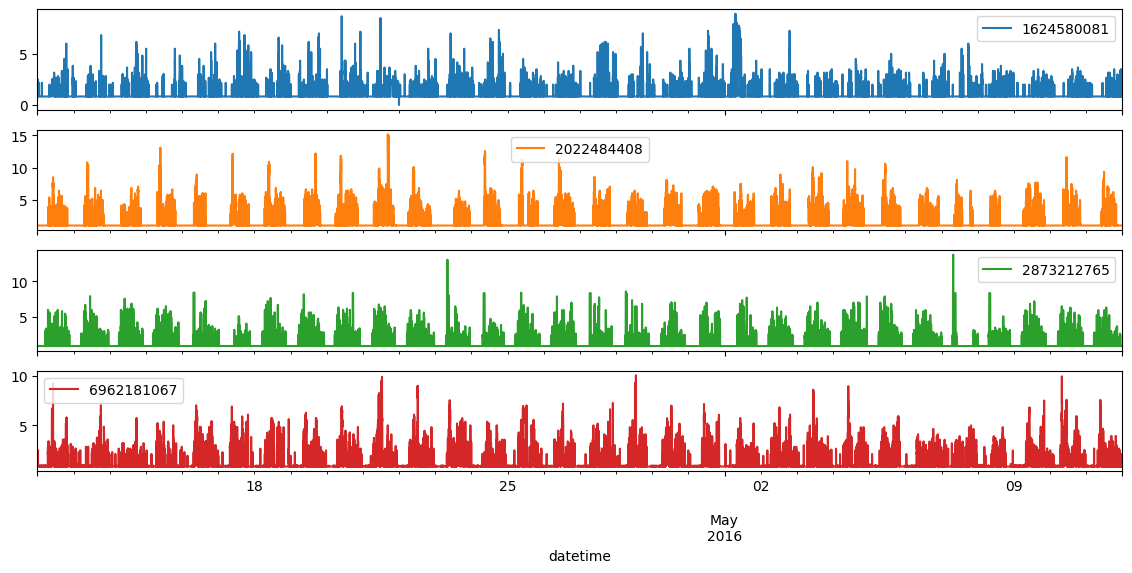

In [376]:
specials = [6962181067, 1624580081, 2022484408, 2873212765]
calories.set_index('Id').loc[specials].reset_index().pivot(index= 'datetime',\
                                                           columns = 'Id', \
                                                           values = 'Calories')\
.plot(subplots= True, figsize = (14,6))

En este caso preferimos utilizar la correlación ya que las series de tiempo son más similares.

array([<AxesSubplot:xlabel='datetime'>, <AxesSubplot:xlabel='datetime'>],
      dtype=object)

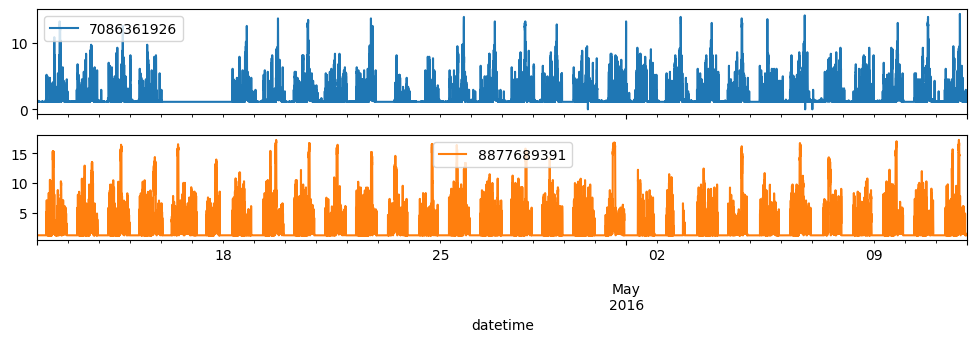

In [378]:
specials = [8877689391 , 7086361926]
calories.set_index('Id').loc[specials].reset_index().pivot(index= 'datetime',\
                                                           columns = 'Id', \
                                                           values = 'Calories')\
.plot(subplots= True, figsize = (12,3))

Ahora añadimos los id's faltantes a los datos de sueño. Siguiendo la siguiente regla:
Los nuevos datos se basan en los del id más cercano de acuerdo al matching que hicimos previamente y agrgamos algo de ruido (añadimos un número aleatorio \* (30 mins) con distribución normal i.e.  una cantidad de minutos en el intervalo -1:30, +1:30 aproximadamente).

In [420]:
df_faltantes_sleep = []
for id_fal in ids_faltantes:
    id_val = df_nearest_corr.set_index('id_fal').loc[id_fal]
    
    df = pd.DataFrame()
    df['datetime'] = new_sleep[new_sleep.Id == id_val[0]].datetime
    df['Id'] = id_fal
    df['TotalMinutesAsleep'] = new_sleep[new_sleep.Id == id_val[0]].TotalMinutesAsleep
    df['TotalTimeInBed'] = new_sleep[new_sleep.Id == id_val[0]].TotalMinutesAsleep
    
    noise1 = np.array(60*np.random.standard_normal(size = 30), dtype = int)
    noise2 = np.array(60*np.random.standard_normal(size = 30), dtype = int)
    
    df['TotalMinutesAsleep'] = df['TotalMinutesAsleep'] + noise1
    df['TotalTimeInBed'] = df['TotalTimeInBed'] + noise2
    df = df[['Id', 'datetime', 'TotalMinutesAsleep', 'TotalTimeInBed']]
    df_faltantes_sleep.append(df)
    

In [423]:
new_sleep = pd.concat([new_sleep, df_faltantes_sleep[0],\
                      df_faltantes_sleep[1],\
                      df_faltantes_sleep[2],\
                      df_faltantes_sleep[3]], ignore_index = True)
new_sleep

,Id,datetime,TotalMinutesAsleep,TotalTimeInBed
0,1844505072,2016-04-12,604.0,961.0
1,1844505072,2016-04-13,702.0,961.0
2,1844505072,2016-04-14,649.0,961.0
3,1844505072,2016-04-15,644.0,961.0
4,1844505072,2016-04-16,681.0,961.0
...,...,...,...,...
565,8877689391,2016-05-07,456.0,426.0
566,8877689391,2016-05-08,499.0,490.0
567,8877689391,2016-05-09,375.0,463.0
568,8877689391,2016-05-10,290.0,409.0


In [425]:
set(calories.Id.unique()) - set(new_sleep.Id.unique())

set()

### Ritmo cardiaco

En este caso de acuero a las líneas de código de abajo heart solo cuenta con 8 id's de los 19 actuales con los que estamos trabajando. Además los tiempos con registros de ritmo cardiaco se encuntran segundo a segundo en algunos casos. En otros hay saltos de 5 segundos o saltos irregulares. Podemos estandarizar estos datos usando el método _resample_ de pandas.

In [427]:
set(heart.Id.unique()) - set(calories.Id.unique())

{2347167796, 5577150313, 6117666160, 6775888955, 7007744171, 8792009665}

In [461]:
heart = all_df['heartrate_seconds_merged'].copy()
# Filter to our desidered id's
heart = heart[heart.Id.isin(calories.Id.unique())]
heart['datetime'] = pd.to_datetime(heart.pop('Time'), format =  '%m/%d/%Y %I:%M:%S %p')
heart.head(2)

,Id,Value,datetime
0,2022484408,97,2016-04-12 07:21:00
1,2022484408,102,2016-04-12 07:21:05


In [480]:
print(len(heart.Id.unique())) # Solo hay 8 id's, de manera que faltan 11!!
heart.pivot(columns= 'Id', values = 'Value', index = 'datetime').head(2) #Fijese que el tiempo va de un seg a otro.

8


Id,2022484408,2026352035,4020332650,4388161847,4558609924,5553957443,6962181067,8877689391
datetime,,,,,,,,
2016-04-12 00:00:00,NaN,NaN,63.0,NaN,NaN,61.0,NaN,NaN
2016-04-12 00:00:01,NaN,NaN,64.0,NaN,NaN,NaN,NaN,NaN


Aquí agregamos los datos por minuto, note que empiezan en la fecha y minuto adecuados. Tomamos el promedio por minuto como método de agregación. Los NaN corresponden a valores que no tienen ni un sólo registro en el rango de tiempo comprendido entre la fila actual y la fila siguiente (abierto). Luego restringimos hasta la fecha y hora de interés de nuestro estudio (2016-05-11 23:59:00).

In [478]:
tabla_heart = heart.pivot(columns= 'Id', values = 'Value', index = 'datetime').resample('1T').mean()
tabla_heart = tabla_heart.loc[:'2016-05-11 23:59:01',:]
print(tabla_heart.head(2).iloc[:,:3]) # Fijese que el día y la hora son los correctos
print(tabla_heart.tail(2).iloc[:,:3]) # Fijese que restringimos a la fecha y hora límite de nuestro estudio

Id                   2022484408  2026352035  4020332650
datetime                                               
2016-04-12 00:00:00         NaN         NaN   63.500000
2016-04-12 00:01:00         NaN         NaN   65.913043
Id                   2022484408  2026352035  4020332650
datetime                                               
2016-05-11 23:58:00         NaN         NaN         NaN
2016-05-11 23:59:00         NaN         NaN         NaN


De nuevo, lo ideal sería preguntar a un stakeholder o al dueño de los conjuntos de datos la razón por la que hayan tantos datos faltantes... ¿Por qué es así? ¿Hay un fallo en la importación de datos? ¿Hay otro dataset con datos completos, debemos cambiar de dataset? ¿Acaso las personas normalmente se quitan el dispositivo y por eso hacen falta registros de ritmo cardiaco?

Sin embargo cómo el propósito de este Notebook es demostratr habilidades de análisis de datos vamos a seguir una metodología similar a la del caso del sueño. De manera que ahora disponemos de un problema. La primera parte del problema sería averigüar la manera adecuada de interpolar los datos de rimto cardíaco. Primero que todo, dichos datos están lejos de seguir una distribucuón normal. Más bien el ritmo cardíaco tiene un comportamiento sinusoidal a lo largo del día. Los datos de calorías, intensidades y MET deberían ayudarnos a estimar los valores faltantes.

**Fast check**
Podemos ver que intensidades y MET están intimamente relacionado con ritmo cardiaco. Al menos para el caso del id 4020332650

<AxesSubplot:title={'center':'Steps'}, xlabel='datetime'>

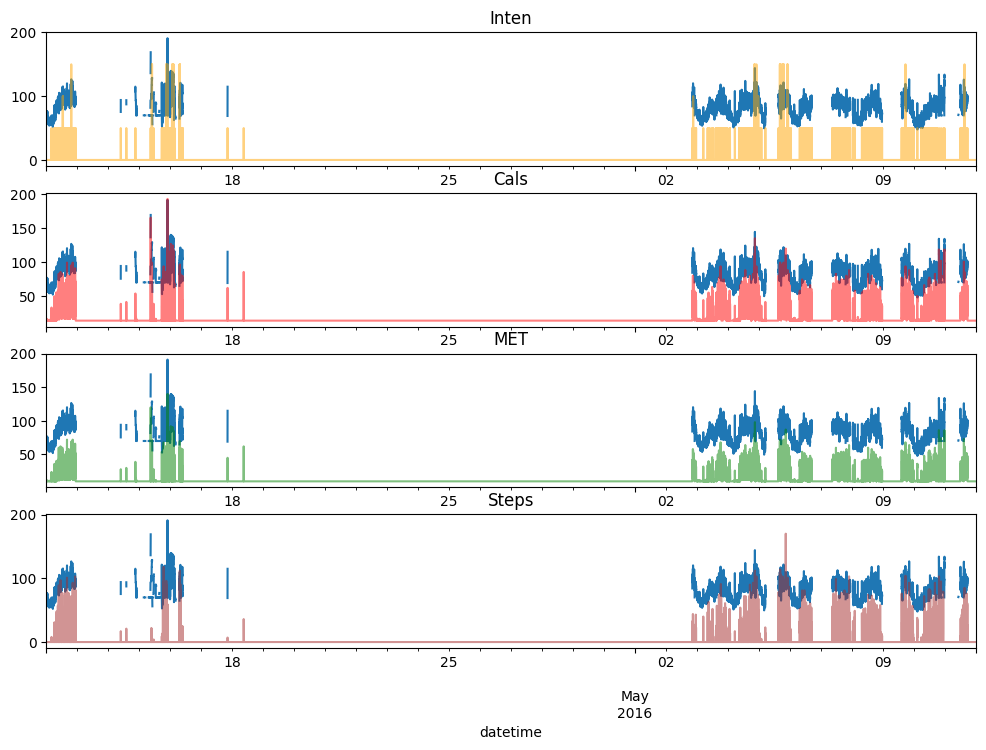

In [550]:
fig,ax = plt.subplots(4,1, figsize= (12,8))
tabla_heart[4020332650].plot(ax = ax[0])
(intensities[intensities.Id == 4020332650].set_index('datetime')['Intensity']*50).plot(color = 'orange', alpha = 0.5, ax = ax[0], title = 'Inten')


tabla_heart[4020332650].plot(ax = ax[1])
(calories[calories.Id == 4020332650].set_index('datetime')['Calories']*10).plot(color = 'red', alpha = 0.5, ax = ax[1], title = 'Cals')

tabla_heart[4020332650].plot(ax = ax[2])
(MET[MET.Id == 4020332650].set_index('datetime')['METs']).plot(color = 'green', alpha = 0.5, ax = ax[2], title='MET')

tabla_heart[4020332650].plot(ax = ax[3])
(steps[steps.Id == 4020332650].set_index('datetime')['Steps']).plot(color = 'brown', alpha = 0.5, ax = ax[3], title = 'Steps')



¿Cuál es el comportamiento típico de MET cuando no hay registros de ritmo cardíaco? 

In [591]:
print(MET[MET.Id == 4020332650].set_index('datetime').METs.iloc[500:600].value_counts()) # Sabemos que en los primeros registros hay actividad
print(MET[MET.Id == 4020332650].set_index('datetime').METs.iloc[5000:5100].value_counts()) # Cuál es el valor típioc de los peridoso debaja actividad?

13    29
12    27
36     9
15     6
30     4
38     4
28     4
32     3
14     2
26     2
42     2
34     2
40     2
11     2
24     1
60     1
Name: METs, dtype: int64
10    98
12     1
11     1
Name: METs, dtype: int64


#### Correlación de ritmo cardíaco con Calories, intentsities, MET and Steps.

A continuación podemos observar un comportamiento idéntico para Calories y METs. Es posible que el cálculo de Mets dependa de calorías de forma directa. En un solo caso calorías tiene una correlación ligeramente mayor +0.01.

In [551]:
def corr_with_cal(series):
    id_actual = series.name
    cals = calories[calories.Id == id_actual].set_index('datetime')['Calories']
    METS = MET[MET.Id == id_actual].set_index('datetime')['METs']
    inten = intensities[intensities.Id == id_actual].set_index('datetime')['Intensity']
    ste = steps[steps.Id == id_actual].set_index('datetime')['Steps']
    
    return pd.Series([cals.corr(series), inten.corr(series), METS.corr(series), ste.corr(series)], \
                     index = ['Cals','Intensities','MET','Steps'])


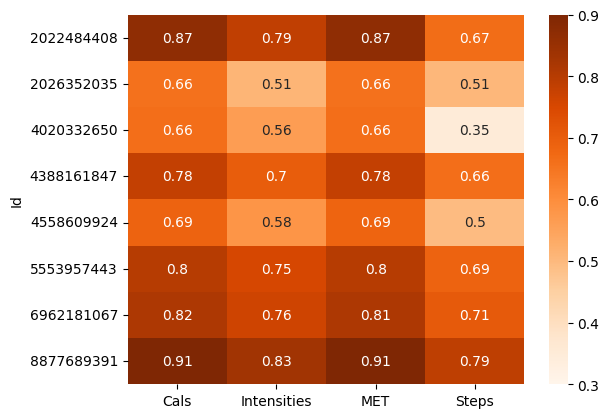

In [552]:
ax = sns.heatmap(tabla_heart.agg(corr_with_cal).T, vmax = .9, vmin= 0.3 , annot = True,\
                linecolor = 'yellow', cmap='Oranges')

Hasta ahora hemos notados dos cosas:

1) Faltan muchos registros de ritmo cardíaco. Una hipótesis es que hay una relación fuerte entre la ausencia de registros de ritmo cardíaco y los registros bajos de Calorías y MET. Puede que esto se deba a que los usuarios remueven su dispositivo y por eso no hay marcación de sus signos vitales. Esto es importante porque **podría ser un indicador del comportamiento de los usuarios**. Dicho lo anterior no vale la pena hacer una interpolación porque establecería un claro sesgo. Reemplazamos los valores faltantes por cero para indicar ausencia de registros (o marcación según nuestra hipótesis). No creemos que se deba a un fallo en la medición del dispositvo, pero es otra posibilidad.
2) De todas las variables las de mayor correlación con ritmo cardíaco fueron MET y Calorías. Usaremos esto para crear datos ficticios de ritmo cardíaco con dos reglas: a) registros bajos de MET los relacionaremos con marcaciones de cero u ausencia de registros en el ritmo cardíaco, que es un patrón razonable.

In [638]:
new_heart = tabla_heart.fillna(0).stack().reset_index().rename(columns = {0:'Values'}).round({'Values':0})
new_heart.head(2)

,datetime,Id,Values
0,2016-04-12,2022484408,0.0
1,2016-04-12,2026352035,0.0


#### Datos ficticios de ritmo cardiaco siguiendo patrón de MET

Tenemos una alta correlación entre MET y ritmo cardíaco. Ahora bien, como regla general usaremos que a 10 MET cero de ritmo cardíaco. Los valores máximos alcanzados son 202 ppm y 146 MET.

**Nota:** Varios estudios parecen tener una escala diferente para MET. Sin embargo el problema de estimar MET a partir del ritmo cardíaco ha sido ampliamente investigado: [ELSEVIER](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6003065/).
La fórmula que utilizan es $$MET = 0.05 × HRnet + 2$$ 

Dado que la relación establecida en ese estudio es lineal, aquí usaremos un enfoque muy similar. 
Nuestras condiciones iniciales exigen que (Ver caso típico abajo): 

$$MET = 12 = LinearFactor \hspace{2 mm} x \hspace{2 mm} HRnet+ C = LF \hspace{2 mm} x \hspace{2 mm} 80 + \hspace{2 mm} C$$

Y las condiciones finales, serían:

$$MET = 146 = LF \hspace{2 mm} x \hspace{2 mm} HRnet+ C  =  LF \hspace{2 mm} x \hspace{2 mm} 202 + C $$

Resolviendo:
 $$ LF \approx 1.09$$
 $$ C \approx -75$$

In [681]:
print('Maximos')
print(new_heart.Values.max(), '----- HRnet Max') # Max heart rate record.
print(MET[~MET.Id.isin(id_faltantes_heart)].METs.max(), '  ----- MET max') # Max MET recorded ids in heart
print('Casos iniciales')
for i in range(525,530):
    print(MET[MET.Id == 4020332650].set_index('datetime').METs.iloc[i], new_heart[new_heart.Id == 4020332650].set_index('datetime').Values.iloc[i])

Maximos
202.0 ----- HRnet Max
146   ----- MET max
Casos iniciales
12 83.0
13 82.0
13 84.0
12 83.0
13 87.0


#### Algortimo de interpolación 
Para completar los id's faltantes usaremos el siguiente algoritmo:
Si MET < 12 entonces HRnet = 0.
De lo contrario usamos la formula de arriba:
$$HR = \dfrac{MET + 75}{1.09}$$

In [688]:
series_fal_heart = []
for iden in id_faltantes_heart:
    Mets = MET[MET.Id == iden].set_index('datetime').METs
    # We meet our condition with np.where faster than an apply. A group by option will be faster but i cant come across a solution rn.
    ser = pd.Series(np.where( Mets >= 12, (Mets+75)/(1.09), 0 ), index= rango_completo)
    ser.name = iden
    series_fal_heart.append(ser)

In [696]:
df_fal_heart_to_add = pd.concat(series_fal_heart, axis = 1).round(0).stack().reset_index().rename(columns = {'level_0': 'datetime',\
                                                                                      'level_1': 'Id',\
                                                                                       0:'Values'})
new_heart = pd.concat([new_heart, df_fal_heart_to_add])


In [698]:
new_heart.tail(2)

,datetime,Id,Values
475198,2016-05-11 23:59:00,2320127002,0.0
475199,2016-05-11 23:59:00,2873212765,0.0


In [700]:
set(calories.Id.unique()) - set(new_heart.Id.unique())

set()

### Peso

In [32]:
all_df['weightLogInfo_merged']

,Id,Date,WeightKg,WeightPounds,Fat,BMI,IsManualReport,LogId
0,1503960366,5/2/2016 11:59:59 PM,52.599998,115.963147,22.0,22.650000,True,1462233599000
1,1503960366,5/3/2016 11:59:59 PM,52.599998,115.963147,NaN,22.650000,True,1462319999000
2,1927972279,4/13/2016 1:08:52 AM,133.500000,294.317120,NaN,47.540001,False,1460509732000
3,2873212765,4/21/2016 11:59:59 PM,56.700001,125.002104,NaN,21.450001,True,1461283199000
4,2873212765,5/12/2016 11:59:59 PM,57.299999,126.324875,NaN,21.690001,True,1463097599000
...,...,...,...,...,...,...,...,...
62,8877689391,5/6/2016 6:43:35 AM,85.000000,187.392923,NaN,25.440001,False,1462517015000
63,8877689391,5/8/2016 7:35:53 AM,85.400002,188.274775,NaN,25.559999,False,1462692953000
64,8877689391,5/9/2016 6:39:44 AM,85.500000,188.495234,NaN,25.610001,False,1462775984000
65,8877689391,5/11/2016 6:51:47 AM,85.400002,188.274775,NaN,25.559999,False,1462949507000


### Transparencia de los datos
**Nota**: Un punto importante aquí es que los datos fueron suministrados por consentimiento propio de los usuarios respondiendo a una encuesta de Amazon Mechanical Turk. No tenemos claridad sobre la veracidad de los datos de peso. Aparentemente fueron suministrados de manera subjetiva y no por calculos hechos por el dispotivo FitBit. De manera que esta variable no es confiable.

## Data Analysis 
### **¿Cuál es el estado de salud de los usuarios de dispostivos _FitBit_?**

Intentaremos dar respuesta a este tema teniendo en cuenta los siguientes aspectos: 
* ¿Qué tanto hacen ejercicio? ¿Cuál es su duración típica ejercitandose? ¿Prefieren la tarde o la mañana para ejercitarse?
* ¿Su ritmo cardiaco se eleva por tiempos prolongados? ¿O tienen más bien picos cortos?
* ¿Cómo se relaciona su consumo de calorías con el sueño? ¿Duermen bien?




## Apéndice
### A.1 carga de datasets y exploración de tablas

In [2]:
import os
import glob

path = r'C:\Users\diego\Desktop\Books_and_courses\Google_Data_Analysis_Prof_Certificate'                     # use your path
all_files = glob.glob(os.path.join(path, "*.csv"))# advisable to use os.path.join as this makes concatenation OS independent
# Leemos todos los dataframes
li = []
for f in all_files:
    df = pd.read_csv(f)
    li.append(df)
    
# Obtenemos los nombres de todos los archivos csv en este directorio
all_files = os.listdir('C:\\Users\\diego\\Desktop\\Books_and_courses\\Google_Data_Analysis_Prof_Certificate')    
csv_names = list(filter(lambda f: f.endswith('.csv'), all_files))
csv_names = [csv_names[i].replace('.csv', '') for i in range(len(csv_names))]

all_df = pd.Series(li, index = csv_names) # Series con todos los dataframes, indexados por sus nombres.

In [5]:
# Elimine la selección [:2] si desea ver la información de todos los dataframes.
for df in all_df[:2]:
    print( df.info() , '\n ------*-----\n')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 940 entries, 0 to 939
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Id                        940 non-null    int64  
 1   ActivityDate              940 non-null    object 
 2   TotalSteps                940 non-null    int64  
 3   TotalDistance             940 non-null    float64
 4   TrackerDistance           940 non-null    float64
 5   LoggedActivitiesDistance  940 non-null    float64
 6   VeryActiveDistance        940 non-null    float64
 7   ModeratelyActiveDistance  940 non-null    float64
 8   LightActiveDistance       940 non-null    float64
 9   SedentaryActiveDistance   940 non-null    float64
 10  VeryActiveMinutes         940 non-null    int64  
 11  FairlyActiveMinutes       940 non-null    int64  
 12  LightlyActiveMinutes      940 non-null    int64  
 13  SedentaryMinutes          940 non-null    int64  
 14  Calories  

**Notas**
Se puede ver por la información anterior que los datos están separados como tablas relacionales. Algunas tablas sirven de apoyo a otras con información detallada de tiempo en distinta granularidad: diaria, por hora y por minutos. Aparentemente, los datos en _minutosXwide_ y _minutesXnarrow_ solo se diferencian en que una tabla contiene los datos en formato Wide y la otra en formato Long. Se puede decir que hay 4 categorías en las que los datos se encuentran más o menos completos:

* Intensidades
* Calorías
* Pasos
* Sueño

Otras carecterísticas con menor información son: Ritmo cardíaco, MET y peso. Particularmente peso tiene una considerbale cantidad de valores faltantes.

### A.2 Diferencias entre wide y narrow minutes data

In [6]:
# De algunos Id's hay mas registros y de otros menos. 
differences = (60*all_df['minuteCaloriesWide_merged']['Id'].value_counts()).sort_index() \
                - all_df['minuteCaloriesNarrow_merged']['Id'].value_counts().sort_index() #A grandes rasgos hay más datos en Narrow
differences

1503960366     120
1624580081    -420
1644430081   -1440
1844505072    -420
1927972279    -420
2022484408    -360
2026352035    -420
2320127002    -360
2347167796   -1440
2873212765    -660
3372868164   -1440
3977333714    1740
4020332650    -360
4057192912   -1440
4319703577   -1440
4388161847   -1200
4445114986    -360
4558609924   -1140
4702921684    -300
5553957443   -1440
5577150313   -1440
6117666160   -1440
6290855005   -1440
6775888955   -1440
6962181067    -240
7007744171   -1440
7086361926    -780
8053475328    -420
8253242879   -1440
8378563200    -360
8583815059   -1440
8792009665   -1440
8877689391    -360
Name: Id, dtype: int64

In [7]:
differences.value_counts() #At least there is a pattern between id's

-1440    14
-360      6
-420      5
 120      1
-660      1
 1740     1
-1200     1
-1140     1
-300      1
-240      1
-780      1
Name: Id, dtype: int64

In [8]:
# Por exploración sabemos que ambos conjuntos tienen los mismos id's. 
# La diferencia de registros se debe a la diferencia de rangos de fechas en cada dataset.

mins_wide = []
max_wide = []

mins_long = []
max_long = []
for id_number in all_df['minuteCaloriesNarrow_merged']['Id'].unique():
    bool_long = all_df['minuteCaloriesNarrow_merged']['Id'] == id_number 
    bool_wide =  all_df['minuteCaloriesWide_merged']['Id'] == id_number     

    long_data = all_df['minuteCaloriesNarrow_merged'].loc[bool_long, 'ActivityMinute']
    wide_data =  all_df['minuteCaloriesWide_merged'].loc[bool_wide, 'ActivityHour']

    long_data['dates'] =  pd.to_datetime(long_data, format = '%m/%d/%Y %I:%M:%S %p' )
    wide_data['dates'] =  pd.to_datetime(wide_data, format = '%m/%d/%Y %I:%M:%S %p' )
    
    print(id_number)
    print('WIDE', 'min:', min(wide_data['dates']) ,'MAX:', max(wide_data['dates']) )
    print('LONG:','min:' , min(long_data['dates']), 'MAX:' , max(long_data['dates']), '\n')
    mins_wide.append(min(wide_data['dates']))
    mins_long.append(min(long_data['dates']))
    max_wide.append(max(wide_data['dates']))
    max_long.append(max(long_data['dates']))
    



1503960366
WIDE min: 2016-04-13 00:00:00 MAX: 2016-05-12 22:00:00
LONG: min: 2016-04-12 00:00:00 MAX: 2016-05-11 20:59:00 

1624580081
WIDE min: 2016-04-13 00:00:00 MAX: 2016-05-13 08:00:00
LONG: min: 2016-04-12 00:00:00 MAX: 2016-05-12 15:59:00 

1644430081
WIDE min: 2016-04-13 00:00:00 MAX: 2016-05-11 11:00:00
LONG: min: 2016-04-12 00:00:00 MAX: 2016-05-11 11:59:00 

1844505072
WIDE min: 2016-04-13 00:00:00 MAX: 2016-05-13 03:00:00
LONG: min: 2016-04-12 00:00:00 MAX: 2016-05-12 10:59:00 

1927972279
WIDE min: 2016-04-13 00:00:00 MAX: 2016-05-13 08:00:00
LONG: min: 2016-04-12 00:00:00 MAX: 2016-05-12 15:59:00 

2022484408
WIDE min: 2016-04-13 00:00:00 MAX: 2016-05-13 08:00:00
LONG: min: 2016-04-12 00:00:00 MAX: 2016-05-12 14:59:00 

2026352035
WIDE min: 2016-04-13 00:00:00 MAX: 2016-05-13 08:00:00
LONG: min: 2016-04-12 00:00:00 MAX: 2016-05-12 15:59:00 

2320127002
WIDE min: 2016-04-13 00:00:00 MAX: 2016-05-13 08:00:00
LONG: min: 2016-04-12 00:00:00 MAX: 2016-05-12 14:59:00 

23471677

Con la gráfica de abajo resulta evidente que las diferencias en cantidad de registros en Calorías para Wide y narrow minutes se deben a que los datos pertenecen a rangos diferentes. Como regla general los datos de Calorías en Narrow (i.e. Long) empiezan un día antes (2016-04-12) que los datos en Wide (2016-04-13). Sin embargo, la mayor diferencia en registros se debe a los rangos máximos. En la mayoría de los casos Wide tiene una fecha mayor que long. En otros casos coinciden. No hay un rango de fechas largo que garantize que se contendrían ambos registros. De manera que no es compatible usar tanto Wide como Long. Lo recomendable es hacer una elección

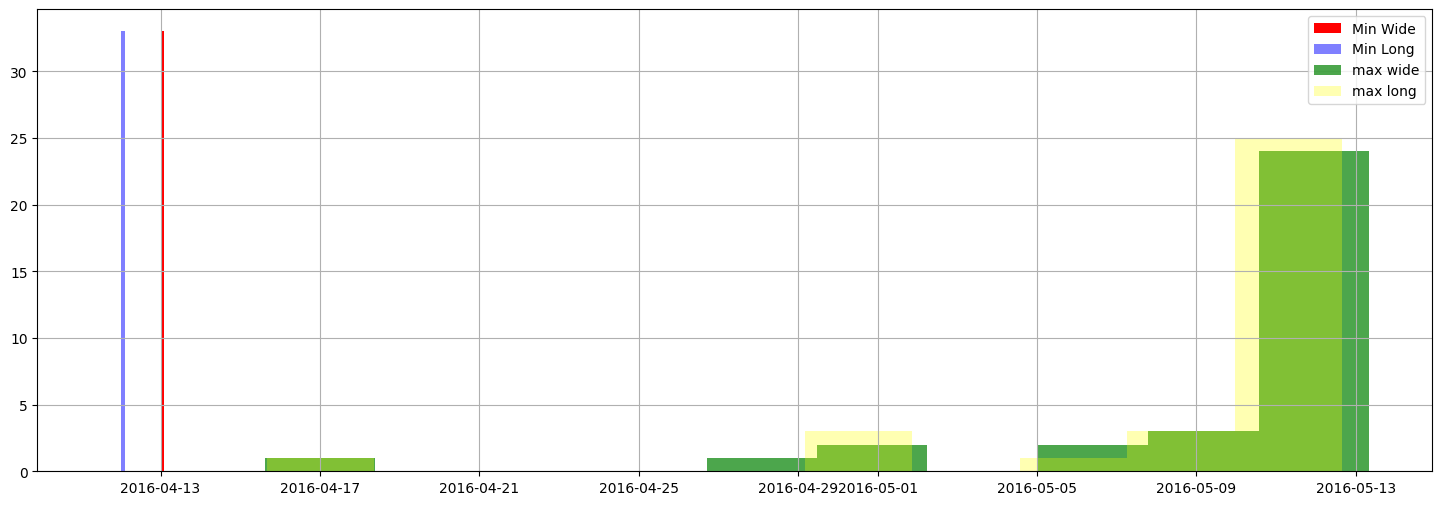

In [11]:
fig = plt.figure(figsize = (18,6))

pd.Series(mins_wide).hist(color = 'red', alpha = 1, label = 'Min Wide')
pd.Series(mins_long).hist(color = 'blue', alpha = 0.5 , label = 'Min Long')
pd.Series(max_wide).hist(color = 'green', alpha = 0.7, label = 'max wide')
pd.Series(max_long).hist(color = 'yellow', alpha = 0.3, label = 'max long')

plt.legend()

### A.3 Elección de minutes de acuerdo a consistencia con Hourly, Daily

Sabemos que los datos tienen una estructura jerárquica. Están agrupados por minutos -> Horas -> Días.

* ¿Los datos por horas representan los promedios cada 60 minutos? r:// No, son la suma de minutes Narrow
* ¿Acaso los datos por horas coinciden con los datos en long o en narrow format? r:// Narrow
* ¿Y los datos diarios sí coinciden con alguna agregación de los datos por horas? r://

Como paso previo convertimos todos los datos a formato datetime.

In [12]:
all_df['hourlyCalories_merged']['datetime'] = pd.to_datetime( all_df['hourlyCalories_merged'].pop('ActivityHour'), \
                                                         format = '%m/%d/%Y %I:%M:%S %p' )
all_df['hourlyCalories_merged']

,Id,Calories,datetime
0,1503960366,81,2016-04-12 00:00:00
1,1503960366,61,2016-04-12 01:00:00
2,1503960366,59,2016-04-12 02:00:00
3,1503960366,47,2016-04-12 03:00:00
4,1503960366,48,2016-04-12 04:00:00
...,...,...,...
22094,8877689391,126,2016-05-12 10:00:00
22095,8877689391,192,2016-05-12 11:00:00
22096,8877689391,321,2016-05-12 12:00:00
22097,8877689391,101,2016-05-12 13:00:00


Se usó **Narrow** minutes para agregar los datos. Long format es más adecuado para realizar calculos y además tiene más observaciones. Se identificó que los datos agrupados por horas representan la suma total de las calorías en minutos Narrow. 

In [13]:
all_df['minuteCaloriesNarrow_merged']['datetime'] = pd.to_datetime(all_df['minuteCaloriesNarrow_merged'].pop('ActivityMinute'), \
                                                         format = '%m/%d/%Y %I:%M:%S %p' )


In [14]:
all_df['minuteCaloriesNarrow_merged']['Day_and_hour'] = all_df['minuteCaloriesNarrow_merged']['datetime'].dt.strftime('%Y-%m-%d %H')
all_df['minuteCaloriesNarrow_merged'].groupby(['Id','Day_and_hour'])['Calories'].sum()

Id          Day_and_hour 
1503960366  2016-04-12 00     81.324098
            2016-04-12 01     60.560498
            2016-04-12 02     58.830198
            2016-04-12 03     47.189999
            2016-04-12 04     47.504599
                                ...    
8877689391  2016-05-12 09     88.134207
            2016-05-12 10    126.079197
            2016-05-12 11    192.270776
            2016-05-12 12    320.774579
            2016-05-12 13    101.469507
Name: Calories, Length: 22093, dtype: float64

In [15]:
all_df['minuteCaloriesWide_merged']['ActivityHour'] = pd.to_datetime(all_df['minuteCaloriesWide_merged']['ActivityHour'], \
                                                         format = '%m/%d/%Y %I:%M:%S %p' )
values = all_df['minuteCaloriesWide_merged'].iloc[:, 2:].apply('sum', axis = 'columns')
values.index = all_df['minuteCaloriesWide_merged'][['Id','ActivityHour']]

In [16]:
values

(1503960366, 2016-04-13 00:00:00)     68.740098
(1503960366, 2016-04-13 01:00:00)     48.133799
(1503960366, 2016-04-13 02:00:00)     47.189999
(1503960366, 2016-04-13 03:00:00)     52.695498
(1503960366, 2016-04-13 04:00:00)     47.347299
                                        ...    
(8877689391, 2016-05-13 03:00:00)     73.020000
(8877689391, 2016-05-13 04:00:00)     73.020000
(8877689391, 2016-05-13 05:00:00)     73.020000
(8877689391, 2016-05-13 06:00:00)     99.307200
(8877689391, 2016-05-13 07:00:00)    164.173302
Length: 21645, dtype: float64

Veamos ahora los datos diarios

In [17]:
all_df['dailyCalories_merged']['datetime'] = pd.to_datetime(all_df['dailyCalories_merged'].pop('ActivityDay'))
all_df['dailyCalories_merged']

,Id,Calories,datetime
0,1503960366,1985,2016-04-12
1,1503960366,1797,2016-04-13
2,1503960366,1776,2016-04-14
3,1503960366,1745,2016-04-15
4,1503960366,1863,2016-04-16
...,...,...,...
935,8877689391,2847,2016-05-08
936,8877689391,3710,2016-05-09
937,8877689391,2832,2016-05-10
938,8877689391,3832,2016-05-11


Aunque los valores son cercanos, notamos algunas inconsistencias significativas. Posiblemente se deba a que la agregación en Hourly se hizo redondeando cifras.

In [18]:
all_df['hourlyCalories_merged']['date'] = all_df['hourlyCalories_merged']['datetime'].dt.date
all_df['hourlyCalories_merged'].groupby(['Id','date'])['Calories'].sum()

Id          date      
1503960366  2016-04-12    1988
            2016-04-13    1798
            2016-04-14    1776
            2016-04-15    1745
            2016-04-16    1866
                          ... 
8877689391  2016-05-08    2840
            2016-05-09    3695
            2016-05-10    2826
            2016-05-11    3827
            2016-05-12    1771
Name: Calories, Length: 934, dtype: int64

In [19]:
# Finalmente vemors dailyActivity que parece ser el dataset más grande
all_df['dailyActivity_merged'].head()

,Id,ActivityDate,TotalSteps,TotalDistance,TrackerDistance,LoggedActivitiesDistance,VeryActiveDistance,ModeratelyActiveDistance,LightActiveDistance,SedentaryActiveDistance,VeryActiveMinutes,FairlyActiveMinutes,LightlyActiveMinutes,SedentaryMinutes,Calories
0,1503960366,4/12/2016,13162,8.50,8.50,0.0,1.88,0.55,6.06,0.0,25,13,328,728,1985
1,1503960366,4/13/2016,10735,6.97,6.97,0.0,1.57,0.69,4.71,0.0,21,19,217,776,1797
2,1503960366,4/14/2016,10460,6.74,6.74,0.0,2.44,0.40,3.91,0.0,30,11,181,1218,1776
3,1503960366,4/15/2016,9762,6.28,6.28,0.0,2.14,1.26,2.83,0.0,29,34,209,726,1745
4,1503960366,4/16/2016,12669,8.16,8.16,0.0,2.71,0.41,5.04,0.0,36,10,221,773,1863


**Notas**: De acuerdo a lo anterior podemos suponer que los datos se corresponden con los encontrados en Narrow minutes. 
Las demás tablas se construyeron como agregaciones de Narrow minutes. Encontramos pequeñas inconsistencias en dichas agregaciones,
posiblemente debido a aproximaciones. En DailyActivity encontramos el merge de todos los datos.